In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
from torchvision import datasets, transforms
from torch.optim import Optimizer
from torch.optim import SGD
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA


In [ ]:
!pip install pyvacy

  Created wheel for pyvacy: filename=pyvacy-0.0.32-py3-none-any.whl size=12400 sha256=454b404c47f85add7aaa7e17f1a1b47de67708dbe2dd03a9216f54824ed5cc3f
  Stored in directory: /root/.cache/pip/wheels/91/57/69/167efbb7af7af54b541e91cc5f917800d79b7052fa7ff1982c
Successfully built pyvacy


In [ ]:
from pyvacy.analysis.moments_accountant import moments_accountant


In [ ]:
def data_preprocessing_dp(n_components=60):
  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

  train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
  test_data = datasets.MNIST('./data', train=False, download=True, transform=transform)

  X_train = train_data.data.view(-1, 28*28)
  y_train = train_data.targets
  X_test = test_data.data.view(-1, 28*28)
  y_test = test_data.targets

  pca_layer = PCA(n_components=n_components)
  X_train = pca_layer.fit_transform(X_train)
  X_train = torch.Tensor(X_train).view(-1, n_components)
  X_test = pca_layer.transform(X_test)
  X_test = torch.Tensor(X_test).view(-1, n_components)

  return X_train, y_train, X_test, y_test

In [ ]:
class Classifier0(nn.Module):
  def __init__(self, in_features=60, hidden_units=1000, out_features=10):
    super(Classifier0, self).__init__()
    self.hidden = nn.Linear(in_features, hidden_units)
    self.relu = nn.ReLU()
    self.outlayer = nn.Linear(hidden_units, out_features)
    self.softmax = nn.LogSoftmax(dim=1)
  
  def forward(self, x):
    x = self.hidden(x)
    x = self.relu(x)
    x = self.outlayer(x)
    x = self.softmax(x)

    return x

In [ ]:
class DP_SGD(SGD):
  def __init__(self, clip, noise, batch_size, lot_size, *args, **kwargs):
    super(DP_SGD, self).__init__(*args, **kwargs)

    self.clip = clip
    self.noise = noise
    self.batch_size = batch_size
    self.lot_size = lot_size

    for group in self.param_groups:
      group['accum_grads'] = [torch.zeros_like(param.data) if param.requires_grad else None for param in group['params']]

  def zero_batch_grad(self):
    super(DP_SGD, self).zero_grad()

  def zero_grad(self):
    for group in self.param_groups:
      for accum_grad in group['accum_grads']:
        if accum_grad is not None:
          accum_grad.zero_()
  
  def batch_step(self):
    total_norm = 0
    for group in self.param_groups:
      for param in group['params']:
        if param.requires_grad:
          total_norm = total_norm + param.grad.data.norm(2).item() ** 2.
    total_norm = total_norm ** 0.5
    clip_coef = min(self.clip / (total_norm + 1e-6), 1.)

    for group in self.param_groups:
      for param, accum_grad in zip(group['params'], group['accum_grads']):
        if param.requires_grad:
          accum_grad.add_(param.grad.data.mul(clip_coef))
  
  def step(self, *args, **kwargs):
    for group in self.param_groups:
      for param, accum_grad in zip(group['params'], group['accum_grads']):
        if param.requires_grad:
          param.grad.data = accum_grad.clone()
          param.grad.data.add_(self.clip * self.noise * torch.randn_like(param.grad.data))
          param.grad.data.mul_(self.batch_size / self.lot_size)
    super(DP_SGD, self).step(*args, **kwargs)

In [ ]:
class IIDBatchSampler:
  def __init__(self, dataset, lot_size, iterations):
    self.length = len(dataset)
    self.lot_size = lot_size
    self.iterations = iterations

  def __iter__(self):
    for _ in range(self.iterations):
      indices = np.where(torch.rand(self.length) < (self.lot_size / self.length))[0]
      if indices.size > 0:
        yield indices
  def __len__(self):
    return self.iterations


In [ ]:
def get_data_loaders(batch_size, lot_size, iterations, drop_last=True):
  def lot_loader(dataset):
    return DataLoader(dataset, batch_sampler=IIDBatchSampler(dataset, lot_size, iterations))
  
  def batch_loader(lot):
    return DataLoader(lot, batch_size=batch_size, drop_last=drop_last)

  return lot_loader, batch_loader


In [ ]:
def model_dptrain(model, optimizer, scheduler, criterion, batch_loader, lot_loader, evaluate):
  iterations = 0
  for X_lot, y_lot in lot_loader:
    optimizer.zero_grad()

    for X_batch, y_batch in batch_loader(TensorDataset(X_lot, y_lot)):
      optimizer.zero_batch_grad()
      prediction = model(X_batch)
      loss = criterion(prediction, y_batch)
      loss.backward()
      optimizer.batch_step()
    optimizer.step()
    

    if iterations % 100 == 0:
      print(f"Iterations: {iterations}, Epochs: {iterations/100}")
      evaluate()
      if iterations <= 1000 and iterations >= 100:
        for params_group in optimizer.param_groups:
          params_group['lr'] = params_group['lr'] - 0.0048;
        print(f"learning rate: {params_group['lr']}")
    
    iterations = iterations + 1

In [ ]:
def evaluate_call(model, train_data, test_data, train_acc_list, test_acc_list):
  def evaluate_func():
    train_pred = model(train_data[:][0]).argmax(dim=1)
    train_acc = round(((train_pred==train_data[:][1]).sum() / len(train_pred)).item(), 4)
    train_acc_list.append(train_acc)

    test_pred = model(test_data[:][0]).argmax(dim=1)
    test_acc = round(((test_pred==test_data[:][1]).sum() / len(test_pred)).item(), 4)
    test_acc_list.append(test_acc)

    print(f"Training Accuracy: {train_acc}, Test Accuracy: {test_acc}")

  return evaluate_func


In [ ]:
lot_size = 600
batch_size = 1
lr_init = 0.1
lr_final = 0.052
iterations = 10000
grad_clip = 4
noise_mul = 8 ### parameter to change
delta = 1e-5

In [ ]:
torch.manual_seed(0)
X_train, y_train, X_test, y_test = data_preprocessing_dp()
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

lot_loader_func, batch_loader = get_data_loaders(batch_size, lot_size, iterations)
lot_loader = lot_loader_func(train_dataset)

model = Classifier0()

train_acc_list = []
test_acc_list = []

optimizer = DP_SGD(clip=grad_clip, 
                   noise=noise_mul,
                   batch_size=batch_size, 
                   lot_size=lot_size, 
                   lr=lr_init, 
                   params=model.parameters())
print('Achieves ({}, {})-DP'.format(
        moments_accountant(
            len(train_dataset),
            lot_size,
            noise_mul,
            iterations / 100,
            delta
        ),
        delta,
    ))

model_dptrain(model=model, 
              optimizer=optimizer, 
              scheduler=[],
              criterion=nn.NLLLoss(), 
              batch_loader=batch_loader, 
              lot_loader=lot_loader, 
              evaluate=evaluate_call(model, train_dataset, test_dataset, train_acc_list, test_acc_list))




  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Achieves (0.6118460567697057, 1e-05)-DP
Iterations: 0, Epochs: 0.0
Training Accuracy: 0.1498, Test Accuracy: 0.1443
Iterations: 100, Epochs: 1.0
Training Accuracy: 0.689, Test Accuracy: 0.6958
learning rate: 0.0952


In [ ]:
epochs = np.arange(0, 100, 1)
plt.plot(epochs, train_acc_list, color='r', label='train accuracy')
plt.plot(epochs, test_acc_list, color='b', label='test accuracy')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('MNIST classifier with medium noise DP') ### 4: medium 2: small
plt.legend()

plt.show()

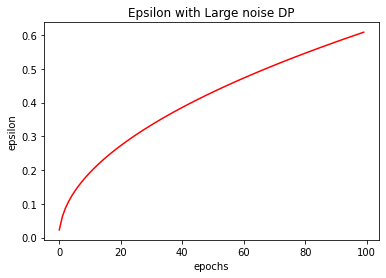

In [ ]:
epochs = np.arange(0, 100, 1)
noise_mul=8
epsilon_dp8 = []
for i in range(len(epochs)):
  epsilon_dp8.append(moments_accountant(len(train_dataset),
            lot_size,
            noise_mul,
            i,
            delta))
  
plt.plot(epochs, epsilon_dp8, color='r')
plt.xlabel('epochs')
plt.ylabel('epsilon')
plt.title('Epsilon with Large noise DP') ### 4: medium 2: small


plt.show()

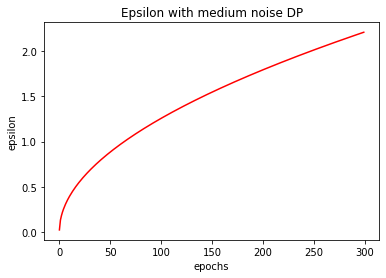

In [ ]:
epochs = np.arange(0, 300, 1)
noise_mul = 4
epsilon_dp4 = []
for i in range(len(epochs)):
  epsilon_dp4.append(moments_accountant(len(train_dataset),
            lot_size,
            noise_mul,
            i,
            delta))

plt.plot(epochs, epsilon_dp4, color='r')
plt.xlabel('epochs')
plt.ylabel('epsilon')
plt.title('Epsilon with medium noise DP') ### 4: medium 2: small


plt.show()

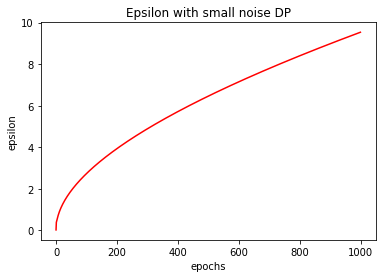

In [ ]:
epochs = np.arange(0, 1000, 1)
noise_mul = 2
epsilon_dp2 = []
for i in range(len(epochs)):
  epsilon_dp2.append(moments_accountant(len(train_dataset),
            lot_size,
            noise_mul,
            i,
            delta))
  
plt.plot(epochs, epsilon_dp2, color='r')
plt.xlabel('epochs')
plt.ylabel('epsilon')
plt.title('Epsilon with small noise DP') ### 4: medium 2: small


plt.show()

In [ ]:
print(epsilon_dp2)

NameError: ignored